## Basic PLD implementation on dippers

Perhaps this is useless because everest-pipeline (which is more powerful than will be shown below) was tested on these data (in the `all dipper download using everest.ipynb`) and no special results seem apparent. 

In [1]:
import everest
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline

In [2]:
epic = 203843911
star = everest.Everest(epic)

INFO  [everest.user.DownloadFile()]: Found cached file.
INFO  [everest.user.load_fits()]: Loading FITS file for 203843911.


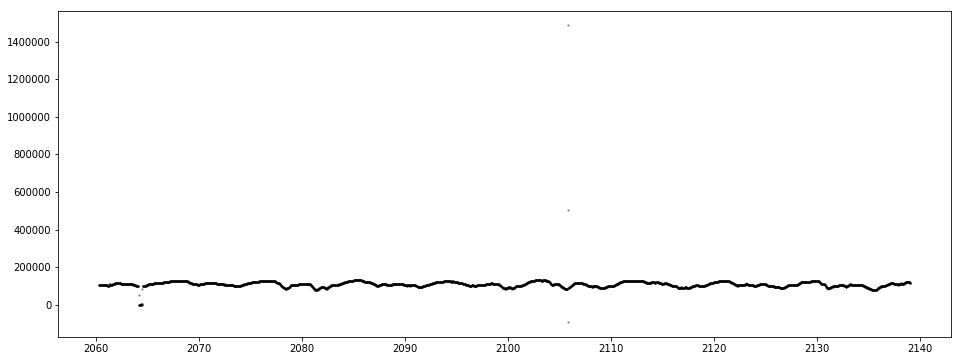

In [3]:
fig = pl.figure(figsize=(16,6))
pl.plot(star.time, star.fraw, 'k.', alpha=0.3, ms=3)

there are plenty of outliers, let's zoom in

(70000, 140000)

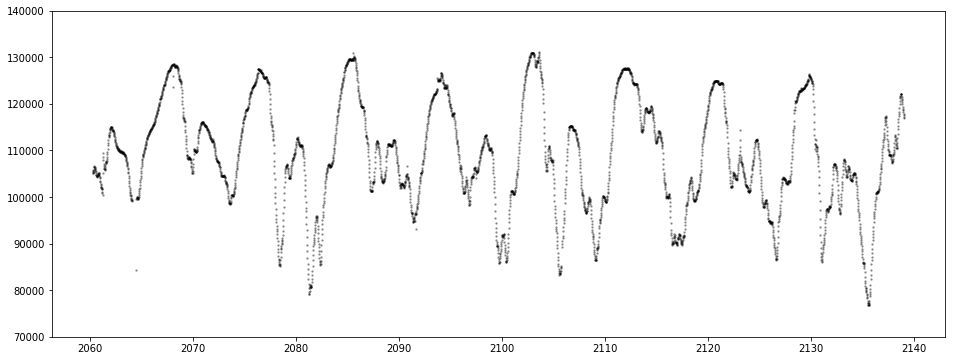

In [4]:
fig = pl.figure(figsize=(16,6))
pl.plot(star.time, star.fraw, 'k.', alpha=0.3, ms=3)
pl.ylim(70000,140000)

Now, let's trim the data as displayed above

In [5]:
star.fraw.max()

1485993.0078125

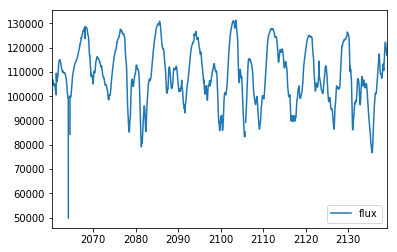

In [6]:
import pandas as pd
EPIC153=pd.DataFrame({'flux': star.fraw}, index=star.time)
#remove outliers
sigma=3
EPIC153=EPIC153[np.abs(EPIC153-EPIC153.mean())<=(sigma*EPIC153.std())]
EPIC153.plot()

In [7]:
#vertical cut
cut = np.where(star.fraw < 30000)
time = np.delete(star.time, cut)
#flux per pixel
fpix = np.delete(star.fpix, cut, axis=0)
ntime, npix = fpix.shape
ntime, npix

(3838, 38)

There are 35 pixels each is a time series with 3917 datapoints. Let's plot them.

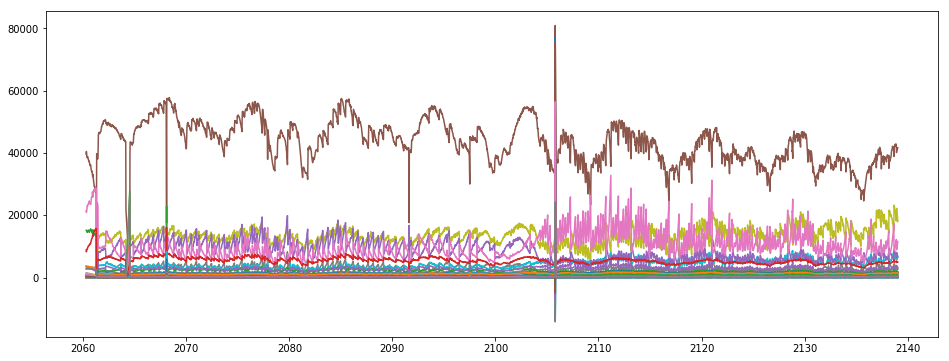

In [8]:
fig = pl.figure(figsize=(16,6))
for n in range(npix):
    pl.plot(time, fpix[:,n])

Similar to doing aperture photometry, sum the point-wise (at each time interval) values resembling the total flux and plot it.

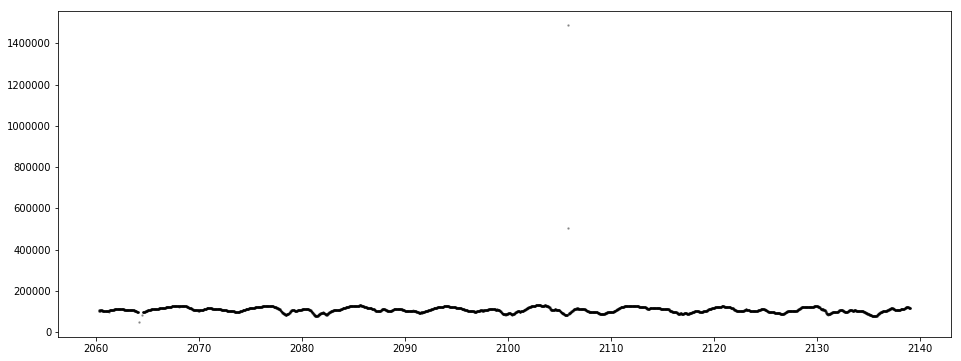

In [9]:
total_flux = np.sum(fpix, axis=1).reshape(-1,1)
fig = pl.figure(figsize=(16,6))
pl.plot(time, total_flux, 'k.', alpha=0.3, ms=3)

Normalize each pixel time series with the total flux containing the transit, variability, systematics, etc.

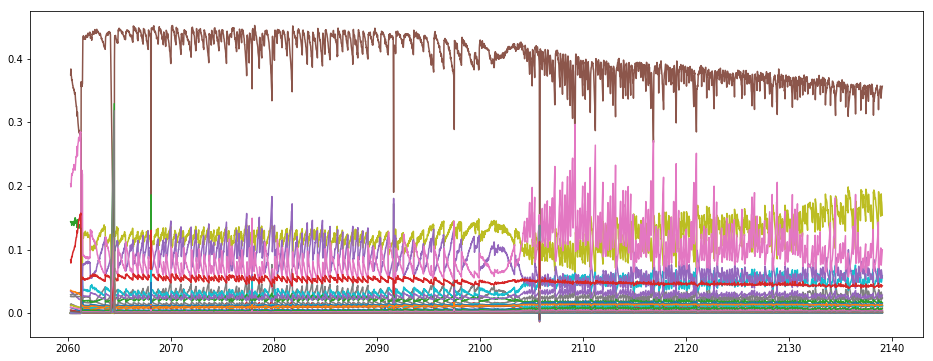

In [10]:
X = fpix / total_flux
fig = pl.figure(figsize=(16,6))
for n in range(npix):
    pl.plot(time, X[:,n])

In [11]:
X.shape

(3838, 38)

Compute the weights of detrending vector given each "normalized pixel light curve," X.
Remember in linear algebra, the matrix should be square to be invertible:
\begin{align}
y=&X \cdot w \\
y\cdot X^T=&X \cdot w \cdot X^T \; (\rm{multiply \;} X^T) \\
(X \cdot X^T)^{-1}y\cdot X^T=& w \; (\rm{solve \; for \;} w)
\end{align}

In [12]:
w = np.linalg.solve(np.dot(X.T,X), np.dot(X.T, total_flux))

Contruct a systematics model by combining the normalized pixel light curve and weights. Then detrend the total flux by subtracting the systematics model. Use std() as a measure of scatter, for comparison later.

In [13]:
model = np.dot(X, w)
detrended_flux = total_flux - model
# preserve the original flux value
detrended_flux += np.nanmedian(total_flux)

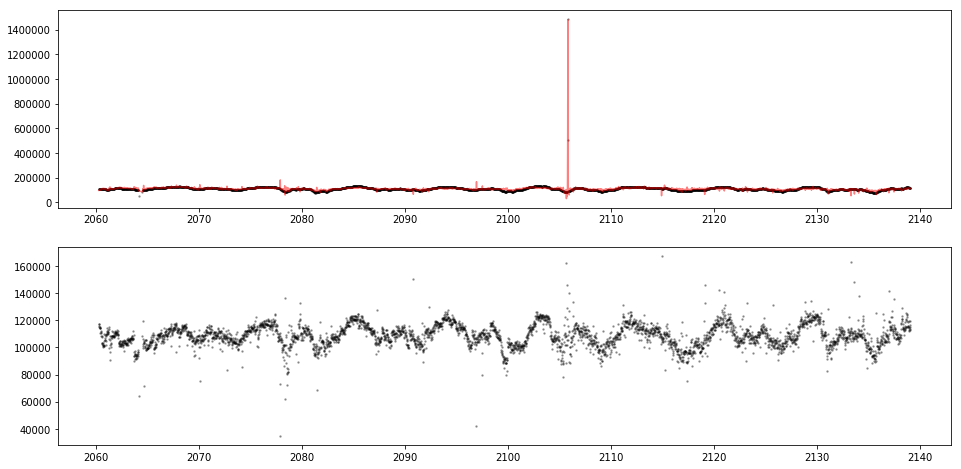

In [14]:
fig, axs = pl.subplots(2, figsize=(16,8))
#raw data
axs[0].plot(time, total_flux, 'k.', alpha=0.3, ms=3)
#model
axs[0].plot(time, model, 'r-', alpha=0.5)
axs[1].plot(time, detrended_flux, 'k.', alpha=0.3, ms=3)

In [15]:
print detrended_flux.std()

8424.3887464


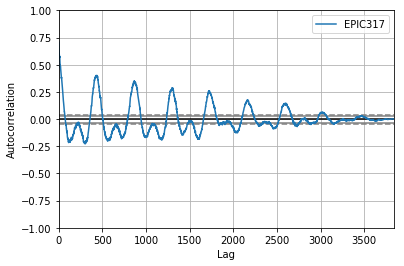

In [16]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(detrended_flux, label='EPIC317');

but can be improved by modeling stellar variability...
==

In [18]:
X = np.hstack((X, np.array([np.linspace(0,2,ntime)**n for n in range(50)]).T))
X.shape

(3838, 88)

The design matrix, X, now has additional columns (35+50=85) besides the pixel light curves (for a 49th order polynomial!). Let's solve for the weights again.

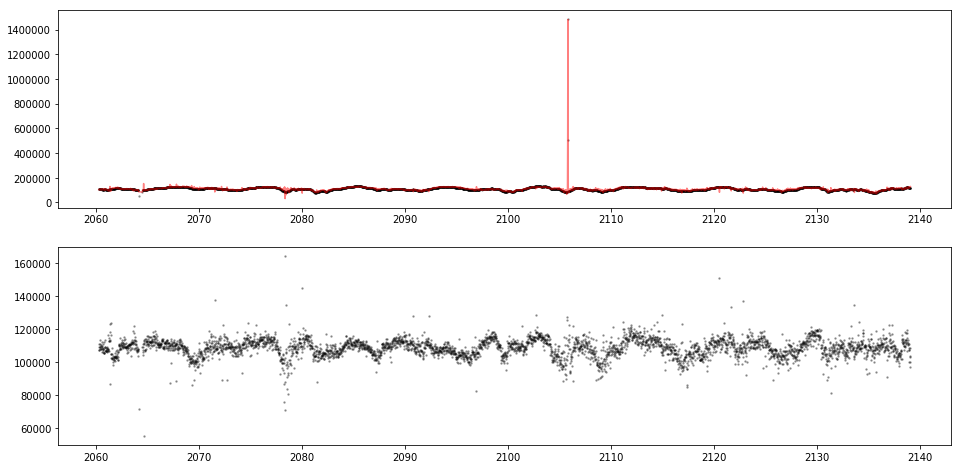

In [19]:
w = np.linalg.solve(np.dot(X.T,X), np.dot(X.T, total_flux))

model = np.dot(X, w)
detrended_flux = total_flux - model
detrended_flux += np.nanmedian(total_flux)

fig, axs = pl.subplots(2, figsize=(16,8))
axs[0].plot(time, total_flux, 'k.', alpha=0.3, ms=3)
axs[0].plot(time, model, 'r-', alpha=0.5)
axs[1].plot(time, detrended_flux, 'k.', alpha=0.3, ms=3)

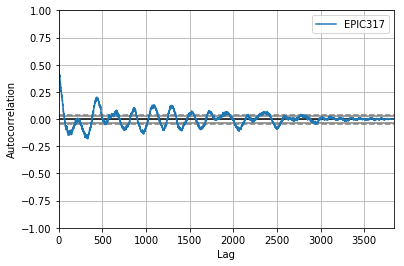

In [20]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(detrended_flux, label='EPIC317');

In [21]:
import gatspy
from gatspy.periodic import LombScargleFast

periods=[]
powers =[]

t, f = star.time, detrended_flux
model = LombScargleFast().fit(t, f)
periods, powers = model.periodogram_auto(nyquist_factor=100)


idx1 = periods > 1.0
idx2 = np.argmax(powers[idx1])
peak = periods[idx1][idx2]
print('{:.2f} d'.format(peak))

393.82 d


In [22]:
print detrended_flux.std()

5667.67878296


The individual transit are even visible already!

much better! now let's try 2nd order PLD...
==

271.566472752


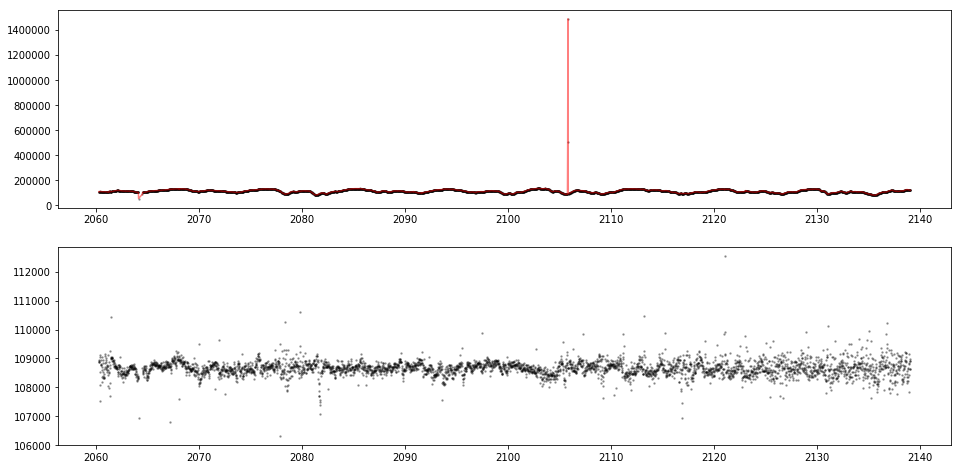

In [23]:
X = np.c_[fpix, fpix**2] / total_flux

X = np.hstack((X, np.array([np.linspace(0,2,ntime)**n for n in range(50)]).T))

w = np.linalg.solve(np.dot(X.T,X), np.dot(X.T, total_flux))

model = np.dot(X, w)
detrended_flux = total_flux - model
detrended_flux += np.nanmedian(total_flux)
print detrended_flux.std()

fig, axs = pl.subplots(2, figsize=(16,8))
axs[0].plot(time, total_flux, 'k.', alpha=0.3, ms=3)
axs[0].plot(time, model, 'r-', alpha=0.5)
axs[1].plot(time, detrended_flux, 'k.', alpha=0.3, ms=3)

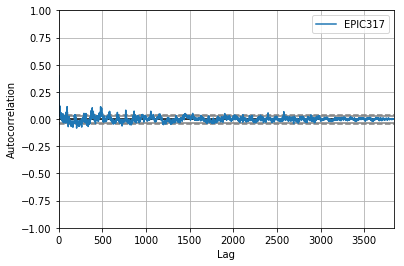

In [24]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(detrended_flux, label='EPIC317');

In [25]:
import gatspy
from gatspy.periodic import LombScargleFast

periods=[]
powers =[]

t, f = star.time, detrended_flux
model = LombScargleFast().fit(t, f)
periods, powers = model.periodogram_auto(nyquist_factor=100)


idx1 = periods > 1.0
idx2 = np.argmax(powers[idx1])
peak = periods[idx1][idx2]
print('{:.2f} d'.format(peak))

393.82 d


In [26]:
print detrended_flux.std()

271.566472752


looks better! how about 3rd order?
==

1326.4487613


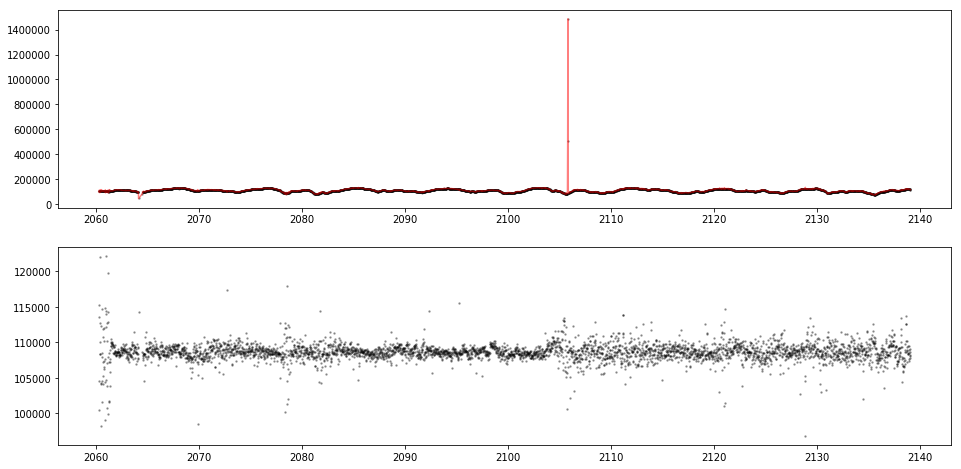

In [27]:
X = np.c_[fpix, fpix**2, fpix**3] / total_flux

# X = np.hstack((X, np.array([np.linspace(0,2,ntime)**n for n in range(50)]).T))
X = np.hstack((X, np.vander(np.linspace(0,2,ntime),50))) # same as above!

w = np.linalg.solve(np.dot(X.T,X), np.dot(X.T, total_flux))

model = np.dot(X, w)
detrended_flux = total_flux - model
detrended_flux += np.nanmedian(total_flux)
print detrended_flux.std()

fig, axs = pl.subplots(2, figsize=(16,8))
axs[0].plot(time, total_flux, 'k.', alpha=0.3, ms=3)
axs[0].plot(time, model, 'r-', alpha=0.5)
axs[1].plot(time, detrended_flux, 'k.', alpha=0.3, ms=3)

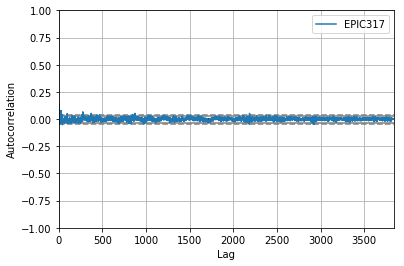

In [28]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(detrended_flux, label='EPIC317');

In [29]:
import gatspy
from gatspy.periodic import LombScargleFast

periods=[]
powers =[]

t, f = star.time, detrended_flux
model = LombScargleFast().fit(t, f)
periods, powers = model.periodogram_auto(nyquist_factor=100)


idx1 = periods > 1.0
idx2 = np.argmax(powers[idx1])
peak = periods[idx1][idx2]
print('{:.2f} d'.format(peak))

393.82 d


In [30]:
print detrended_flux.std()

1326.4487613


Finally, compare result using everest-pipeline api which implements a Gaussian Process model rather than polynomial fittting shown above.

INFO  [everest.user.plot()]: Plotting the light curve...


/home/jp/.local/lib/python2.7/site-packages/everest_pipeline-2.0.8-py2.7.egg/everest/user.py:628: RuntimeWarning: invalid value encountered in less
  for i in np.where(flux < ylim[0])[0]:
/home/jp/.local/lib/python2.7/site-packages/everest_pipeline-2.0.8-py2.7.egg/everest/user.py:644: RuntimeWarning: invalid value encountered in greater
  for i in np.where(flux > ylim[1])[0]:


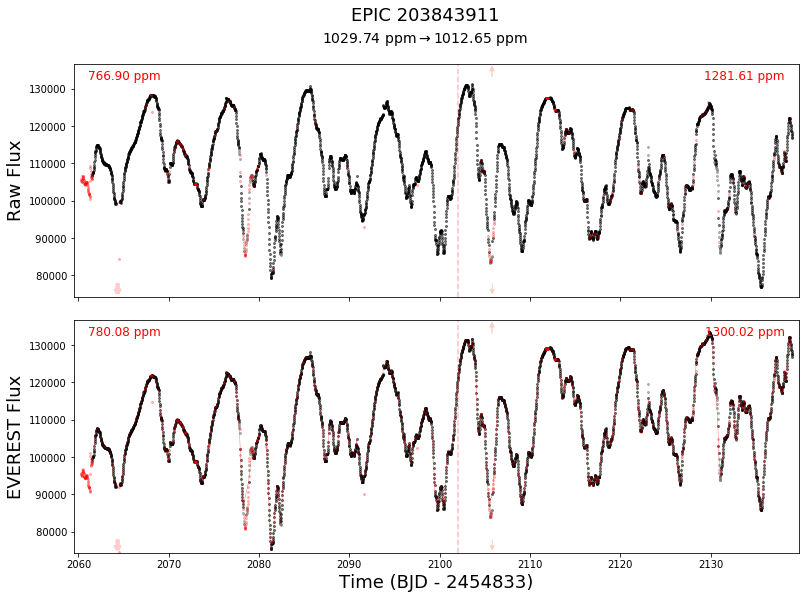

In [31]:
star.plot()